In [128]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import json

In [129]:
DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion-features-1-1097.sqlite'
CONV_DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion.sqlite'
FEATURE_ID = 23
BASE_PEAK_ID = 2
MAX_RT_DISTANCE = 2
MAX_SCAN_DISTANCE = 5
MAX_NUMBER_OF_PEAKS = 20

In [130]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_summed_ms2_regions_1 ON summed_ms2_regions (feature_id, peak_id)")
db_conn.close()

In [131]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_ms2_peaks_2 ON ms2_peaks (feature_id, peak_id)")
db_conn.close()

In [132]:
# Load the peak points for the best CofM-matching peaks for this feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peak_points_df = pd.read_sql_query("select peak_id,mz,scan,intensity from summed_ms2_regions where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, MAX_NUMBER_OF_PEAKS), db_conn)
db_conn.close()

In [133]:
# load the feature's base peak points
db_conn = sqlite3.connect(DB_NAME)
base_peak_points_df = pd.read_sql_query("select point_id,mz,scan,intensity from summed_ms1_regions where feature_id={} and peak_id={}".format(FEATURE_ID, BASE_PEAK_ID), db_conn)
db_conn.close()

In [134]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

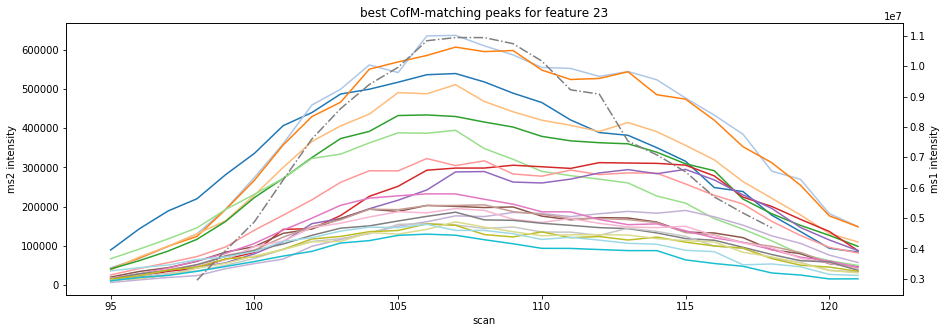

In [135]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
groups = ms2_peak_points_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax1.plot(group.scan, group.intensity, color=tableau20[i%len(tableau20)], label=name)
ax2.plot(base_peak_points_df.scan, base_peak_points_df.intensity, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax1.set_ylabel('ms2 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms1 intensity')
plt.title('best CofM-matching peaks for feature {}'.format(FEATURE_ID))
plt.margins(0.06)
plt.show()

In [136]:
# find the most intense ms2 peaks for this feature that match in centre-of-mass
db_conn = sqlite3.connect(DB_NAME)
peak_correlation_df = pd.read_sql_query("select * from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {}".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, 200), db_conn)
db_conn.close()

In [137]:
# get the ms2 peaks for the feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peaks_df = pd.read_sql_query("select feature_id,peak_id,centroid_mz from ms2_peaks where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, 200), db_conn)
db_conn.close()

In [138]:
ms2_peaks_df.head()

,feature_id,peak_id,centroid_mz
0,23,1,588.361
1,23,2,861.007
2,23,3,861.508
3,23,4,775.952
4,23,5,776.454


In [139]:
peak_correlation_df.head()

,feature_id,base_peak_id,ms1_scan_centroid,ms1_rt_centroid,ms2_peak_id,ms2_scan_centroid,ms2_rt_centroid,scan_distance,rt_distance,correlation
0,23,2,110.144302,1151.36315,1,107.403725,1151.336424,2.740577,0.026726,0.0
1,23,2,110.144302,1151.36315,2,108.975504,1151.332457,1.168798,0.030693,0.0
2,23,2,110.144302,1151.36315,3,108.986546,1151.332787,1.157756,0.030363,0.0
3,23,2,110.144302,1151.36315,4,108.607330,1151.335597,1.536972,0.027553,0.0
4,23,2,110.144302,1151.36315,5,108.514538,1151.333596,1.629764,0.029554,0.0


In [140]:
merged_ms2_peak_df = pd.merge(ms2_peaks_df, peak_correlation_df, left_on=['feature_id','peak_id'], right_on=['feature_id','ms2_peak_id'])

In [141]:
z = np.polyfit(x=merged_ms2_peak_df.centroid_mz, y=merged_ms2_peak_df.scan_distance, deg=1)
p = np.poly1d(z)
merged_ms2_peak_df['trendline'] = p(merged_ms2_peak_df.centroid_mz)

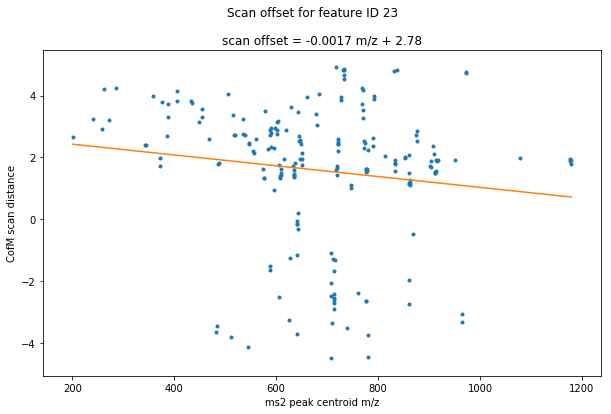

In [142]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.centroid_mz, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
merged_ms2_peak_df.set_index(merged_ms2_peak_df.centroid_mz, inplace=True)
merged_ms2_peak_df.trendline.sort_index(ascending=False).plot(ax=ax1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('CofM scan distance')
plt.margins(0.06)
plt.suptitle('Scan offset for feature ID {}'.format(FEATURE_ID))
plt.title('scan offset = {0:.4f} m/z + {1:.2f}'.format(z[0],z[1]))
plt.show()

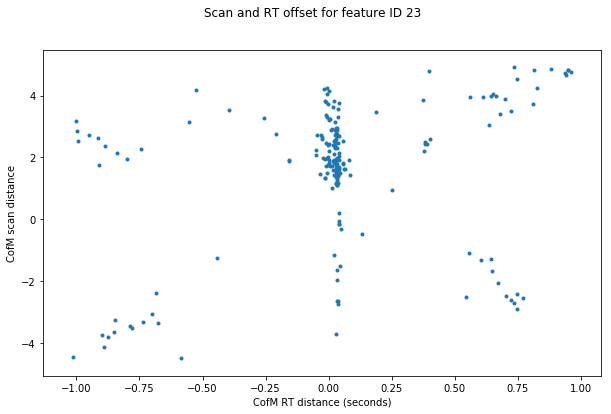

In [143]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.rt_distance, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
plt.xlabel('CofM RT distance (seconds)')
plt.ylabel('CofM scan distance')
plt.margins(0.06)
plt.suptitle('Scan and RT offset for feature ID {}'.format(FEATURE_ID))
plt.show()